In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models

# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models


def train_and_evaluate_cnn_3x3(df, study_list, study_name, epochs=50):
    print(f"\n===== Training 3x3 CNN Autoencoder for {study_name} =====")

    if isinstance(study_list, str):
        study_list = [study_list]

    # --- Filter study ---
    df_filtered = df[df["Study"].isin(study_list)].copy()
    if df_filtered.empty:
        raise ValueError(f"No data found for study {study_name}")

    # --- Normalize antibody names ---
    df_filtered["Property"] = (
        df_filtered["Property"]
        .str.upper()
        .str.replace(r"[^A-Z0-9]", "", regex=True)
    )

    # --- Pivot to wide format (antibodies only for now) ---
    df_wide = df_filtered.pivot_table(
        index="Accession",
        columns="Property",
        values="Value",
        aggfunc="first"
    ).fillna(0)

    # --- Enforce fixed antibody set (5) ---
    expected_ab = ["GAD65", "IA2IC", "MIAA", "ICA", "ZNT8"]
    df_wide = df_wide.reindex(columns=expected_ab, fill_value=0)
    antibody_labels = expected_ab.copy()

    # --- Join demographics ---
    demo_cols = (
        df_filtered[["Accession", "Age_Group", "Sex"]]
        .drop_duplicates()
        .set_index("Accession")
    )
    df_wide = df_wide.join(demo_cols, how="left")

    # --- Define expected demographic categories ---
    expected_age_groups = ["8-12", "13-17", "18-30"]
    expected_sex = {"Male": 0, "Female": 1}

    # --- Scale antibody values ---
    ab_scaler = MinMaxScaler()
    X_ab = ab_scaler.fit_transform(df_wide[antibody_labels].values)  # (n, 5)

    # --- Encode Age_Group deterministically (3 columns) ---
    age_dummies = pd.get_dummies(df_wide["Age_Group"])
    age_dummies = age_dummies.reindex(columns=expected_age_groups, fill_value=0)

    # --- Encode Sex deterministically (1 column) ---
    sex_series = df_wide["Sex"].map(expected_sex).fillna(0).astype(int)

    # --- Combine demographics (n, 4) ---
    X_demo = np.hstack([
        age_dummies.values,
        sex_series.values.reshape(-1, 1)
    ])
    
    # --- Combine → exactly 9 features ---
    X_full = np.hstack([X_ab, X_demo])
    X_full = X_full.astype(np.float32)

    if X_full.shape[1] != 9:
        raise ValueError(f"Expected 9 features, got {X_full.shape[1]}")

    # --- Train/test split ---
    indices = np.arange(X_full.shape[0])
    X_train, X_test, idx_train, idx_test = train_test_split(
        X_full, indices, test_size=0.2, random_state=42
    )

    # --- Reshape to 3×3 image ---
    X_train_img = X_train.reshape(-1, 3, 3, 1)
    X_test_img  = X_test.reshape(-1, 3, 3, 1)

    print(f"X_train_img dtype: {X_train_img.dtype}")  # Should be float32
    print(f"X_test_img dtype: {X_test_img.dtype}")  # Should be float32

    # --- CNN Autoencoder ---
    inputs = layers.Input(shape=(3, 3, 1))

    x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.Flatten()(x)
    encoded = layers.Dense(4, activation="relu")(x)

    x = layers.Dense(9, activation="relu")(encoded)
    x = layers.Reshape((3, 3, 1))(x)
    outputs = layers.Conv2D(1, (3, 3), activation="linear", padding="same")(x)

    autoencoder = models.Model(inputs, outputs)
    autoencoder.compile(optimizer="adam", loss="mse")

    # --- Train ---
    autoencoder.fit(
        X_train_img, X_train_img,
        epochs=epochs,
        batch_size=8,
        validation_data=(X_test_img, X_test_img),
        verbose=0
    )

    # --- Predict ---
    reconstructed = autoencoder.predict(X_test_img)
    reconstructed_flat = reconstructed.reshape(X_test.shape)

    # --- Per-antibody MSE (first 5 columns only) ---
    per_antibody_mse = {
        ab: mean_squared_error(X_test[:, i], reconstructed_flat[:, i])
        for i, ab in enumerate(antibody_labels)
    }

    mse_median = np.median(list(per_antibody_mse.values()))
    mse_iqr = (
        np.percentile(list(per_antibody_mse.values()), 75) -
        np.percentile(list(per_antibody_mse.values()), 25)
    )

    # --- Save model and weights ---
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"{study_name}_3x3_model.keras")
    weights_path = os.path.join(model_dir, f"{study_name}_3x3.weights.h5")

    autoencoder.save(model_path)
    autoencoder.save_weights(weights_path)

    print(f"Saved model:   {model_path}")
    print(f"Saved weights:{weights_path}")
    print(f"Median MSE: {mse_median:.6f}")
    print(f"IQR:        {mse_iqr:.6f}")

    # --- Save test data for federated evaluation ---
    input_feature_names = (
        antibody_labels +
        expected_age_groups +
        ["Sex"]
    )

    df_test_out = pd.DataFrame(X_test, columns=input_feature_names)

    output_dir = "test_data"
    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, f"{study_name}_3x3_test.csv")
    df_test_out.to_csv(csv_path, index=False)
    print(f"Saved test data CSV: {csv_path}")

    # --- Return summary for plotting ---
    df_test_meta = df_wide.iloc[idx_test]

    return {
        "mse_median": mse_median,
        "mse_iqr": mse_iqr,
        "per_antibody_mse": per_antibody_mse,
        "X_train": X_train,
        "X_test": X_test,
        "reconstructed": reconstructed_flat,
        "antibody_labels": antibody_labels,
        "Age_Group": df_test_meta["Age_Group"].values,
        "Sex": df_test_meta["Sex"].values
    }


In [3]:
import pandas as pd

# === 1. Load the full tidy dataset ===
df_all = pd.read_csv("data/tidy_all.csv")

# === 2. Define your study list ===
study_list = ["SDY569", "SDY1625", "SDY524", "SDY797", "SDY1737"]

# === 3. Train and evaluate each study individually ===
mse_summaries_3x3 = {}

for study in study_list:
    print(f"\n--- Training on {study} ---")
    result = train_and_evaluate_cnn_3x3(  
        df=df_all,
        study_list=[study],               # must be a list
        study_name=study,                 # name used for model file
        epochs=50                         # removed max_features — 3x3 always uses 9
    )
    mse_summaries_3x3[study] = result



--- Training on SDY569 ---

===== Training 3x3 CNN Autoencoder for SDY569 =====
X_train_img dtype: float32
X_test_img dtype: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Saved model:   models/SDY569_3x3_model.keras
Saved weights:models/SDY569_3x3.weights.h5
Median MSE: 0.001892
IQR:        0.000680
Saved test data CSV: test_data/SDY569_3x3_test.csv

--- Training on SDY1625 ---

===== Training 3x3 CNN Autoencoder for SDY1625 =====
X_train_img dtype: float32
X_test_img dtype: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Saved model:   models/SDY1625_3x3_model.keras
Saved weights:models/SDY1625_3x3.weights.h5
Median MSE: 0.026425
IQR:        0.045085
Saved test data CSV: test_data/SDY1625_3x3_test.csv

--- Training on SDY524 ---

===== Training 3x3 CNN Autoencoder for SDY524 =====
X_train_img dtype: float32
X_test_img dtype: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Saved model:   models/SDY524_3x3_model.keras
Saved weights:models/SDY524_3x3.weights.h5
Median MSE: 0.034355
IQR:    

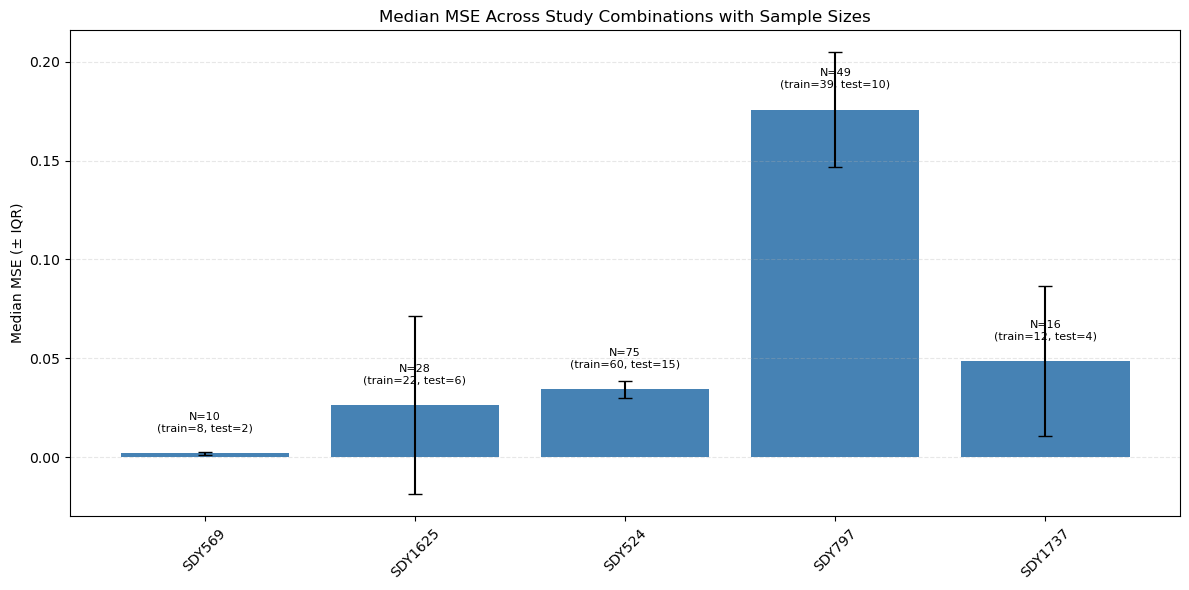

In [4]:
import matplotlib.pyplot as plt

# Get values from mse_summaries_3x3
study_names = list(mse_summaries_3x3.keys())
medians = [mse_summaries_3x3[study]["mse_median"] for study in study_names]
iqrs = [mse_summaries_3x3[study]["mse_iqr"] for study in study_names]
train_sizes = [mse_summaries_3x3[study]["X_train"].shape[0] for study in study_names]
test_sizes = [mse_summaries_3x3[study]["X_test"].shape[0] for study in study_names]

# Bar plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(study_names, medians, yerr=iqrs, capsize=5, color='steelblue')

# Annotate N on top of bars
for bar, train, test in zip(bars, train_sizes, test_sizes):
    height = bar.get_height()
    label = f"N={train+test}\n(train={train}, test={test})"
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=8)

# Formatting
ax.set_ylabel("Median MSE (± IQR)")
ax.set_title("Median MSE Across Study Combinations with Sample Sizes")
ax.set_xticks(range(len(study_names)))
ax.set_xticklabels(study_names, rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:
for study, summary in mse_summaries_3x3.items():
    print(f"\nStudy: {study}")
    print("  Age groups:", summary.get("Age_Group", None))
    print("  Sex:", summary.get("Sex", None))



Study: SDY569
  Age groups: ['8-12' '18-30']
  Sex: ['Female' 'Male']

Study: SDY1625
  Age groups: ['8-12' '8-12' '8-12' '8-12' '8-12' '8-12']
  Sex: ['Female' 'Male' 'Female' 'Male' 'Male' 'Female']

Study: SDY524
  Age groups: ['8-12' '13-17' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '13-17'
 '13-17' '8-12' '13-17' '8-12' '8-12']
  Sex: ['Female' 'Female' 'Male' 'Male' 'Female' 'Male' 'Female' 'Male' 'Male'
 'Male' 'Male' 'Female' 'Male' 'Male' 'Male']

Study: SDY797
  Age groups: ['8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12']
  Sex: ['Male' 'Male' 'Male' 'Female' 'Male' 'Male' 'Male' 'Male' 'Female' 'Male']

Study: SDY1737
  Age groups: ['13-17' '8-12' '13-17' '8-12']
  Sex: ['Female' 'Female' 'Male' 'Female']


In [6]:
def plot_mse_by_sex(mse_summaries_3x3):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    data = []

    for study, summary in mse_summaries_3x3.items():
        X = summary["X_test"]
        Xr = summary["reconstructed"]
        sexes = summary["Sex"]

        for i, sex in enumerate(sexes):
            # FIX: match only the antibody portion
            mse = np.mean((X[i] - Xr[i,])**2)
            data.append({"Study": study, "Sex": sex, "MSE": mse})

    df = pd.DataFrame(data)

    grouped = df.groupby(["Study", "Sex"])["MSE"]
    medians = grouped.median()
    iqrs = grouped.quantile(0.75) - grouped.quantile(0.25)

    studies = df["Study"].unique()
    sexes = df["Sex"].unique()
    x = np.arange(len(studies))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, sex in enumerate(sexes):
        med = [medians.get((study, sex), np.nan) for study in studies]
        err = [iqrs.get((study, sex), 0) for study in studies]
        ax.bar(x + i * width, med, width, yerr=err, capsize=5, label=sex)

    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(studies, rotation=45)
    ax.set_ylabel("Median MSE ± IQR")
    ax.set_title("Median Antibody MSE by Sex (3×3 CNN)")
    ax.legend(title="Sex")
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [7]:
def plot_mse_by_age_group(mse_summaries_3x3):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    data = []

    for study, summary in mse_summaries_3x3.items():
        X = summary["X_test"]
        Xr = summary["reconstructed"]
        ages = summary["Age_Group"]

        for i, age in enumerate(ages):
            # Match shape for antibody features
            mse = np.mean((X[i] - Xr[i,])**2)
            data.append({"Study": study, "Age_Group": age, "MSE": mse})

    df = pd.DataFrame(data)

    grouped = df.groupby(["Study", "Age_Group"])["MSE"]
    medians = grouped.median()
    iqrs = grouped.quantile(0.75) - grouped.quantile(0.25)

    studies = df["Study"].unique()
    age_groups = df["Age_Group"].unique()
    x = np.arange(len(studies))
    width = 0.15

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, age in enumerate(age_groups):
        med = [medians.get((study, age), np.nan) for study in studies]
        err = [iqrs.get((study, age), 0) for study in studies]
        ax.bar(x + i * width, med, width, yerr=err, capsize=5, label=age)

    ax.set_xticks(x + width * len(age_groups) / 2)
    ax.set_xticklabels(studies, rotation=45)
    ax.set_ylabel("Median MSE ± IQR")
    ax.set_title("Median Antibody MSE by Age Group (3×3 CNN)")
    ax.legend(title="Age Group")
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()



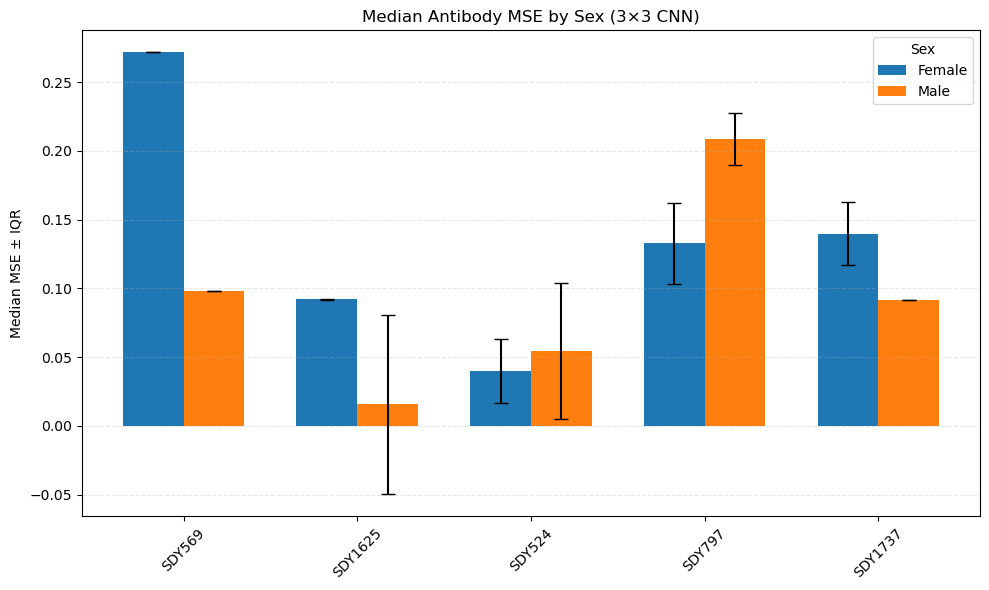

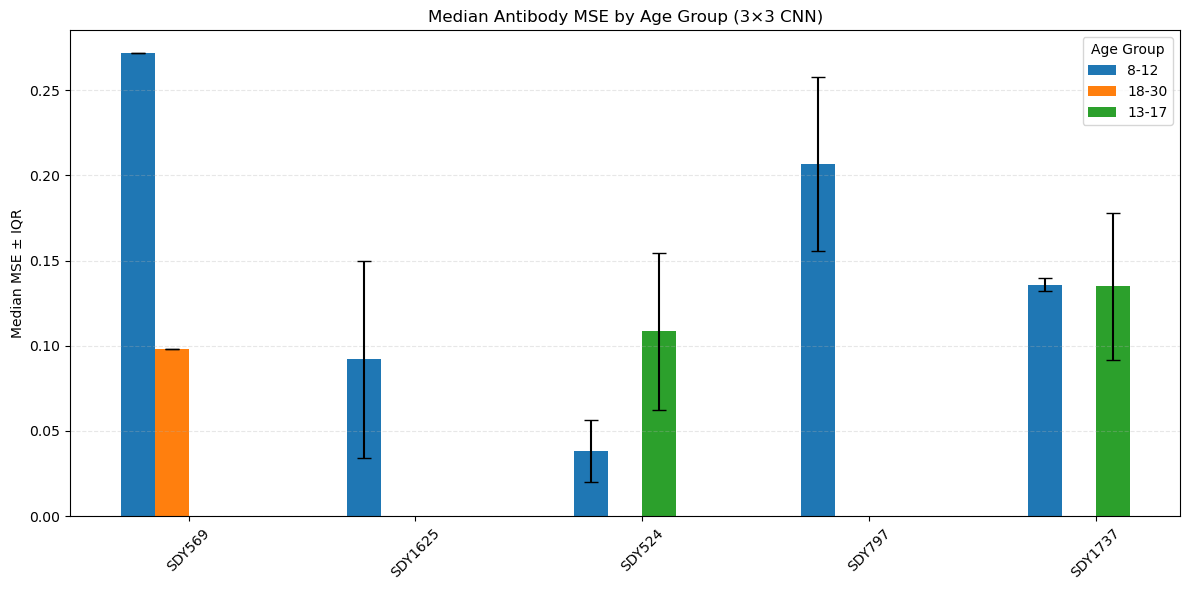

In [8]:
plot_mse_by_sex(mse_summaries_3x3)
plot_mse_by_age_group(mse_summaries_3x3)


In [9]:
def plot_per_antibody_mse(mse_summaries_3x3):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    data = []

    for study, summary in mse_summaries_3x3.items():
        X = summary["X_test"]
        Xr = summary["reconstructed"]
        antibodies = summary["antibody_labels"]

        for i in range(X.shape[0]):
            for j, ab in enumerate(antibodies):
                mse = (X[i, j] - Xr[i, j])**2
                data.append({"Study": study, "Antibody": ab, "MSE": mse})

    df = pd.DataFrame(data)

    grouped = df.groupby(["Study", "Antibody"])["MSE"]
    medians = grouped.median()
    iqrs = grouped.quantile(0.75) - grouped.quantile(0.25)

    studies = df["Study"].unique()
    antibodies = df["Antibody"].unique()
    x = np.arange(len(antibodies))
    width = 0.15

    fig, ax = plt.subplots(figsize=(14, 6))
    for i, study in enumerate(studies):
        med = [medians.get((study, ab), np.nan) for ab in antibodies]
        err = [iqrs.get((study, ab), 0) for ab in antibodies]
        ax.bar(x + i * width, med, width, yerr=err, capsize=5, label=study)

    ax.set_xticks(x + width * len(studies) / 2)
    ax.set_xticklabels(antibodies, rotation=45)
    ax.set_ylabel("Median MSE ± IQR")
    ax.set_title("Per-Antibody Median MSE by Study (3×3 CNN)")
    ax.legend(title="Study")
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


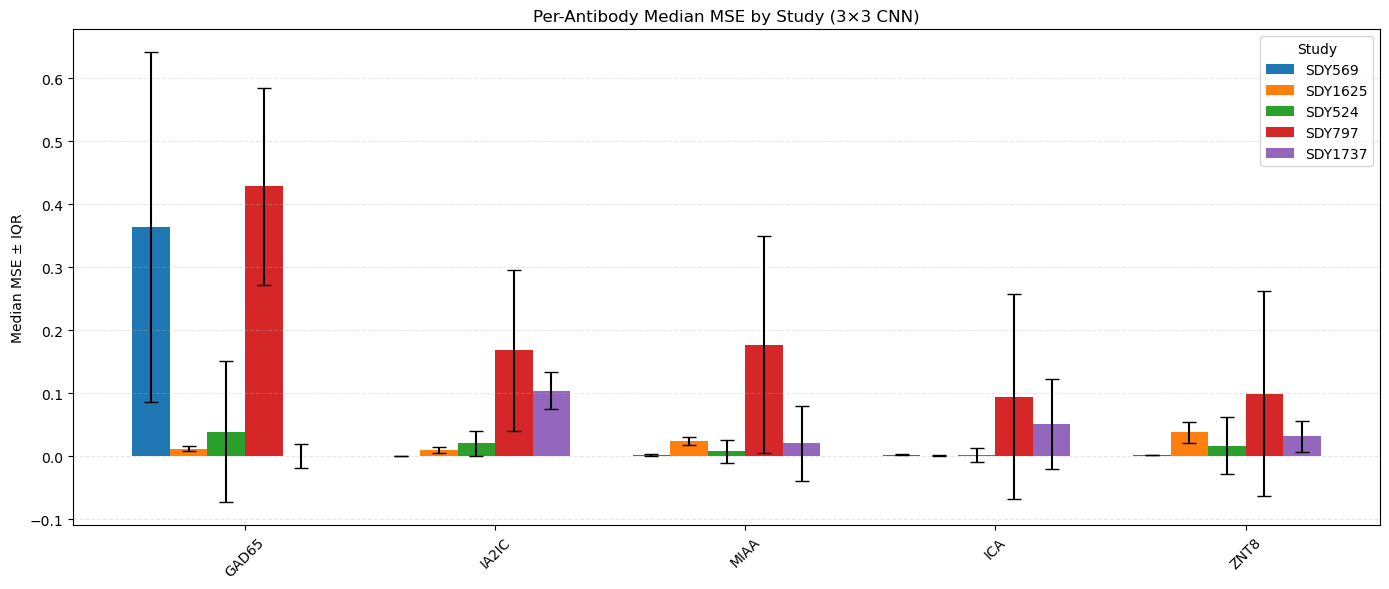

In [10]:
plot_per_antibody_mse(mse_summaries_3x3)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_antibody_mse_by_demographics(mse_summaries, ymax=0.75):
    for study, summary in mse_summaries_3x3.items():
        antibody_labels = summary["antibody_labels"]
        X = summary["X_test"]
        Xr = summary["reconstructed"]
        age_groups = summary["Age_Group"]
        sexes = summary["Sex"]

        # --- Group by Age Group ---
        unique_ages = sorted(set(age_groups))
        fig_age, axes_age = plt.subplots(1, len(unique_ages), figsize=(6 * len(unique_ages), 5), sharey=True)
        if len(unique_ages) == 1:
            axes_age = [axes_age]
        for i, age in enumerate(unique_ages):
            idx = np.where(age_groups == age)[0]
            mse_by_ab = [
                np.mean((X[idx, j] - Xr[idx, j])**2) for j in range(len(antibody_labels))
            ]
            axes_age[i].bar(antibody_labels, mse_by_ab)
            axes_age[i].set_title(f"{study} - Age Group {age}")
            axes_age[i].set_ylabel("MSE")
            axes_age[i].set_ylim(0, ymax)
            axes_age[i].set_xticks(range(len(antibody_labels)))
            axes_age[i].set_xticklabels(antibody_labels, rotation=45)
        fig_age.suptitle(f"Per-Antibody MSE by Age Group — {study}", fontsize=14)
        plt.tight_layout()
        plt.show()

        # --- Group by Sex ---
        unique_sexes = sorted(set(sexes))
        fig_sex, axes_sex = plt.subplots(1, len(unique_sexes), figsize=(6 * len(unique_sexes), 5), sharey=True)
        if len(unique_sexes) == 1:
            axes_sex = [axes_sex]
        for i, sex in enumerate(unique_sexes):
            idx = np.where(sexes == sex)[0]
            mse_by_ab = [
                np.mean((X[idx, j] - Xr[idx, j])**2) for j in range(len(antibody_labels))
            ]
            axes_sex[i].bar(antibody_labels, mse_by_ab)
            axes_sex[i].set_title(f"{study} - Sex: {sex}")
            axes_sex[i].set_ylabel("MSE")
            axes_sex[i].set_ylim(0, ymax)
            axes_sex[i].set_xticks(range(len(antibody_labels)))
            axes_sex[i].set_xticklabels(antibody_labels, rotation=45)
        fig_sex.suptitle(f"Per-Antibody MSE by Sex — {study}", fontsize=14)
        plt.tight_layout()
        plt.show()


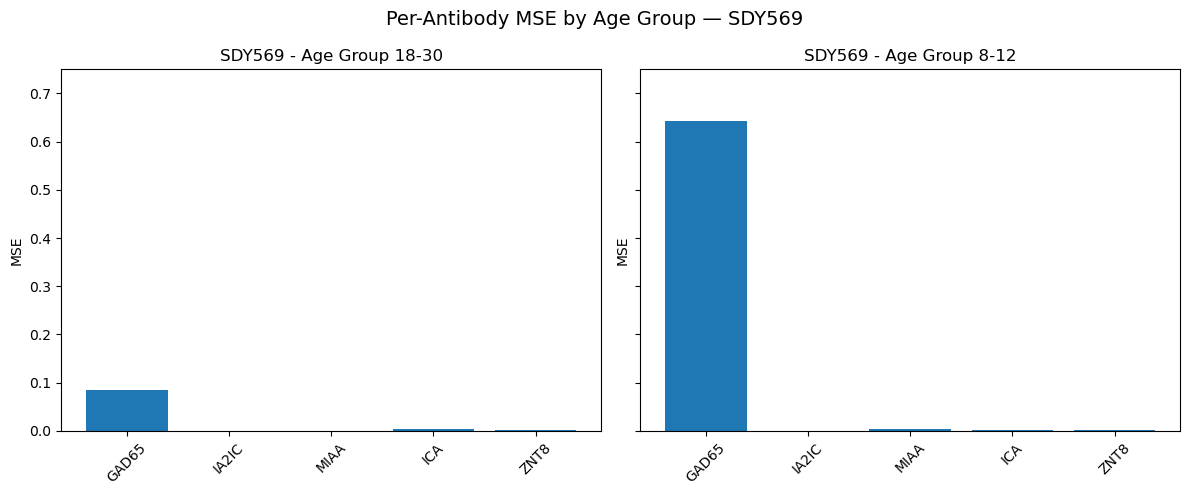

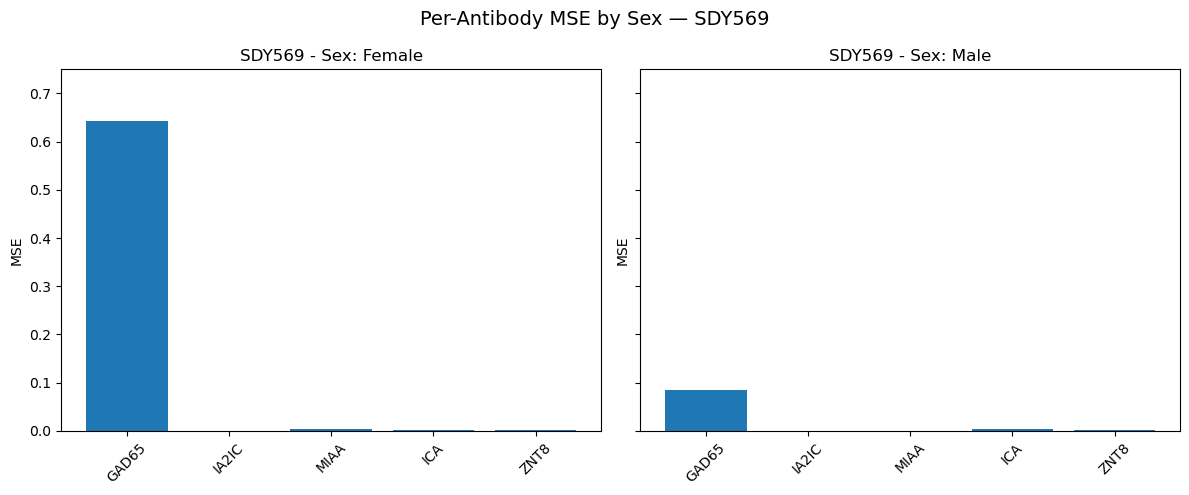

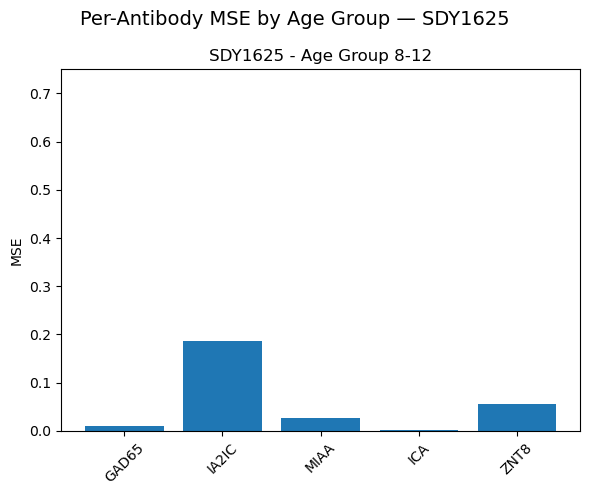

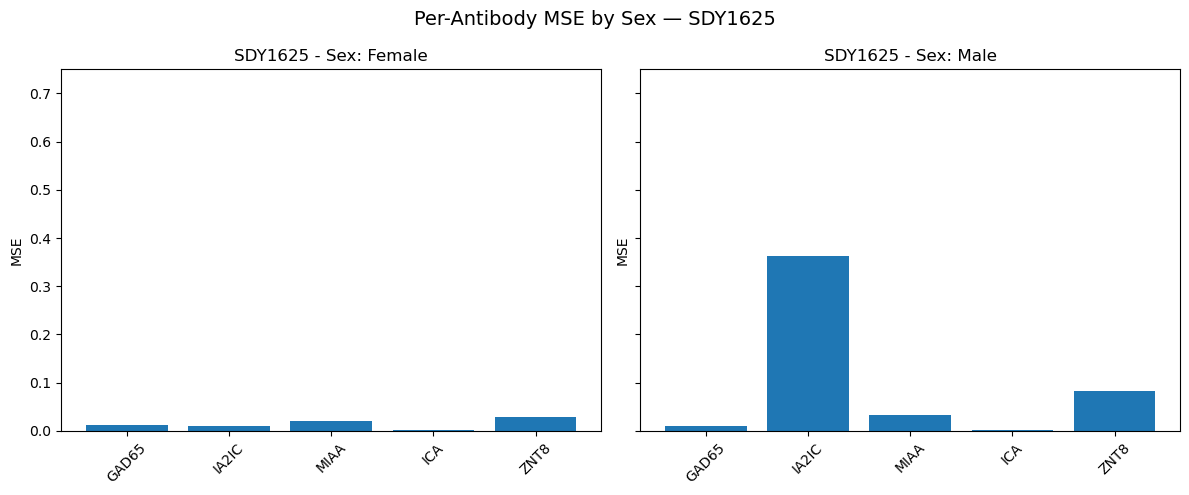

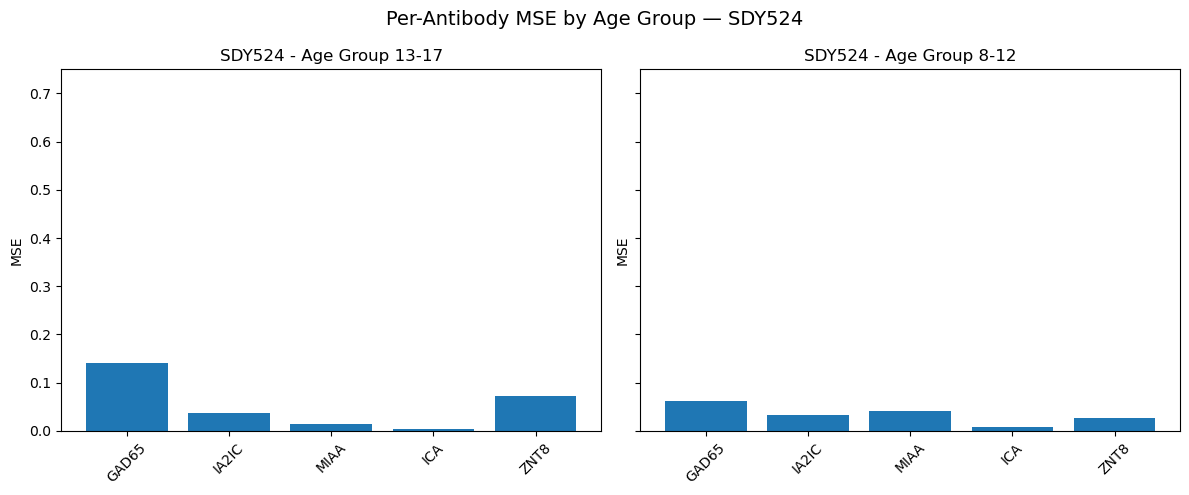

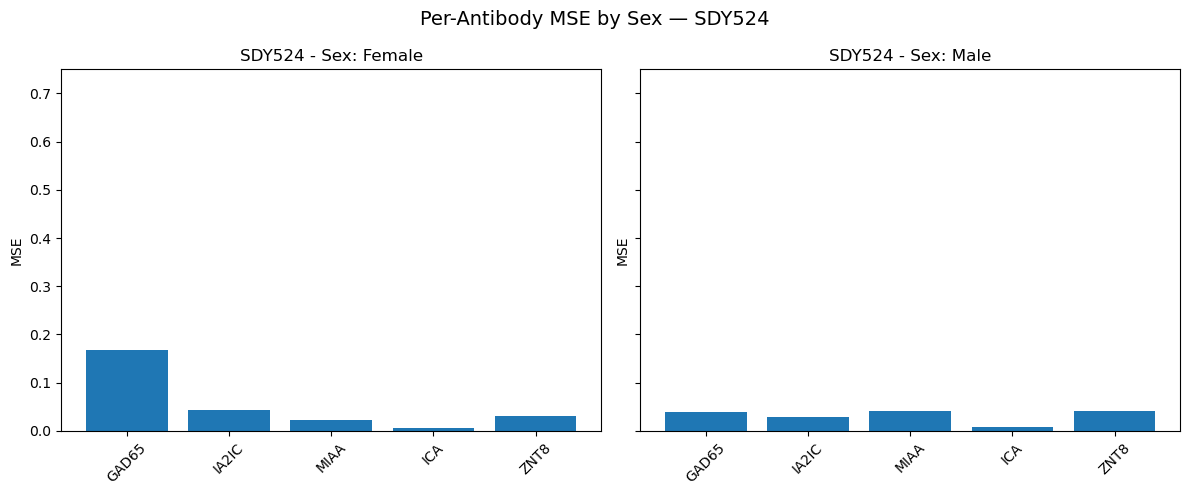

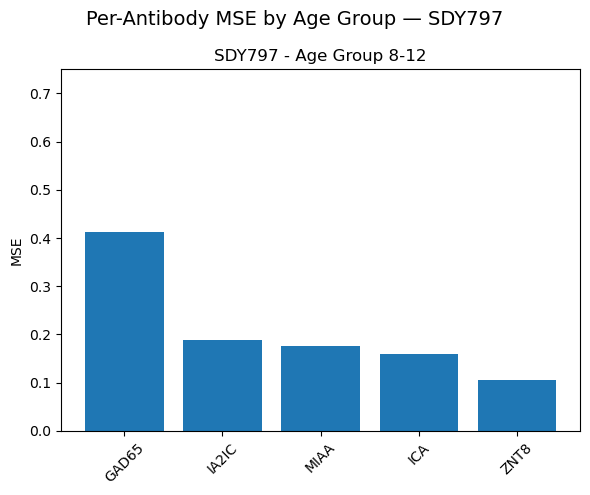

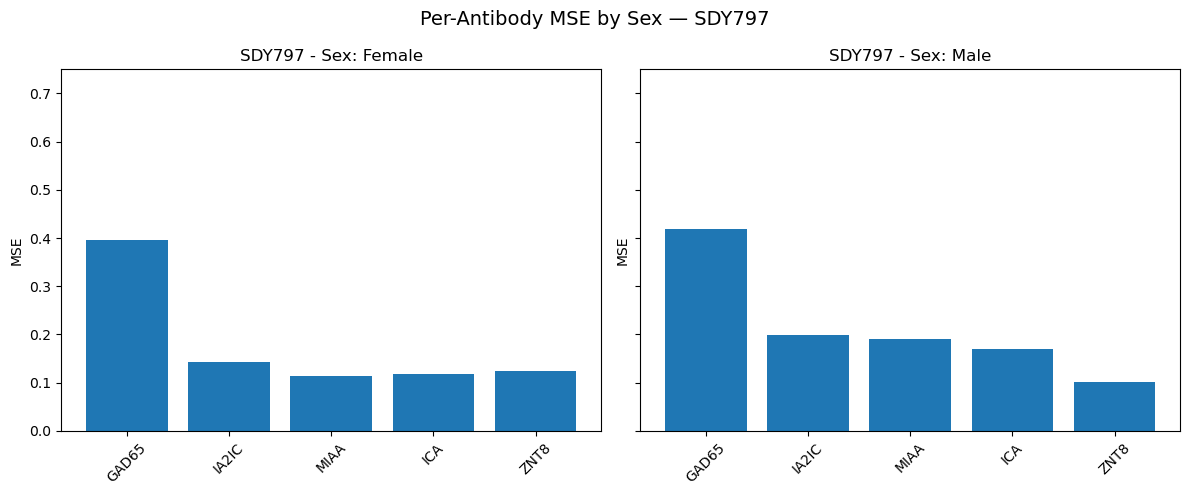

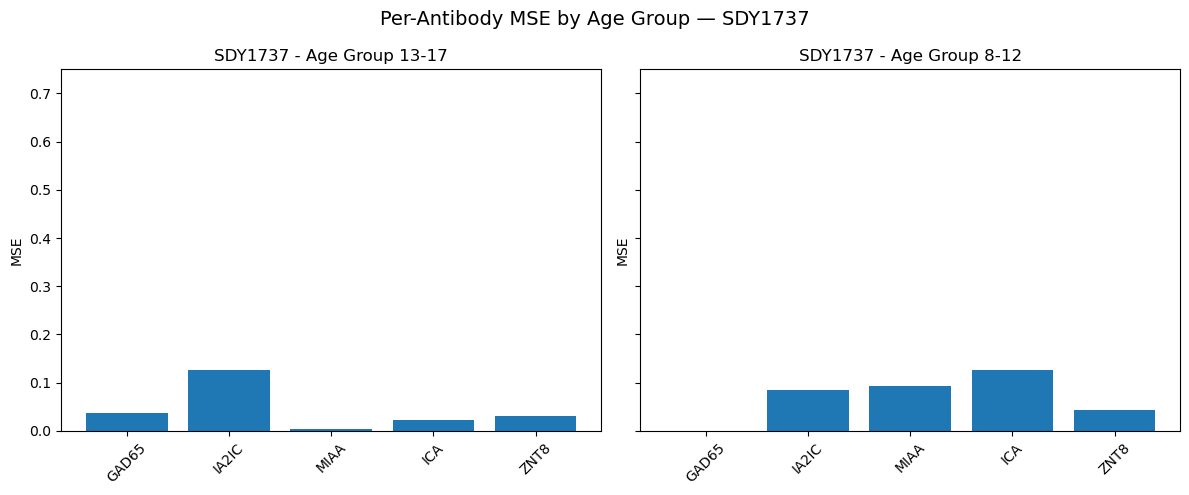

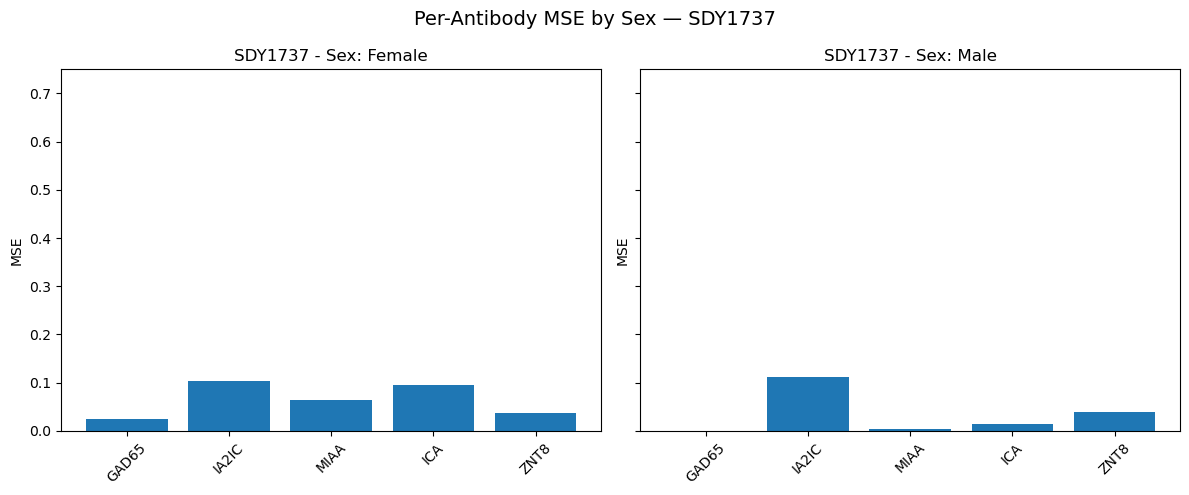

In [12]:
plot_antibody_mse_by_demographics(mse_summaries_3x3)